In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader 
from torch.utils.data import random_split
from torchvision import datasets 
from torchvision import transforms 
from torch.utils.data import Dataset
import glob
from PIL import Image # Image.open(path)
import cv2
import pandas as pd
import albumentations as A # trochvision transforms 보다 빠름(label도 같이 변환가능)
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torchvision.models as models
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
!pip install kaggle
from google.colab import files
files.upload() 

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d ammaralfaifi/5class-weather-status-image-classification
!unzip -q 5class-weather-status-image-classification.zip -d weather

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json
 98% 487M/498M [00:04<00:00, 160MB/s]
100% 498M/498M [00:04<00:00, 128MB/s]


In [8]:
class mySplitFP():
    def __init__(self, root, labels_map):
        self.root, self.labels_map = root, labels_map
        self.dfs = None
        
    def __call__(self):
        return self.split_join_dfs()
        
    def create_dfs(self):
        cloudy_df = pd.DataFrame(data={'filepath':glob.glob(self.root+self.labels_map[0]+'/*.*'), 'label':0})
        foggy_df = pd.DataFrame(data={'filepath':glob.glob(self.root+self.labels_map[1]+'/*.*'), 'label':1})
        rainy_df = pd.DataFrame(data={'filepath':glob.glob(self.root+self.labels_map[2]+'/*.*'), 'label':2})
        snowy_df = pd.DataFrame(data={'filepath':glob.glob(self.root+self.labels_map[3]+'/*.*'), 'label':3})
        sunny_df = pd.DataFrame(data={'filepath':glob.glob(self.root+self.labels_map[4]+'/*.*'), 'label':4})
        self.dfs = [cloudy_df, foggy_df, rainy_df, snowy_df, sunny_df]
        
    def split_join_dfs(self, train_p=0.65, valid_p=0.15, test_p=0.2):
        self.create_dfs()
        idxs_dict = {'train':[], 'valid':[], 'test':[]}
        for df in self.dfs:
            train_n, valid_n = len(df)//(1/train_p), len(df)//(1/valid_p)
            df['cut'] = pd.cut(df.index, bins=[-np.inf, train_n, train_n+valid_n, np.inf], labels=['train','valid','test'])
            for k in idxs_dict.keys():
                idxs_dict[k].append(df.loc[df['cut']==k, ['filepath','label']])
        for k,v in idxs_dict.items():
            if k=='train': train_df = pd.concat(v, axis=0).reset_index()
            elif k=='valid': valid_df = pd.concat(v, axis=0).reset_index()
            elif k=='test': test_df = pd.concat(v, axis=0).reset_index()
        return train_df, valid_df, test_df

In [9]:
root = './weather/data/'
labels_map = {0:'cloudy', 1:'foggy', 2:'rainy', 3:'snowy', 4:'sunny'}
train_df, valid_df, test_df = mySplitFP(root, labels_map).__call__()

In [10]:
transform1 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees = (0, 90)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ToTensor()
])

transform2 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [11]:
class createDataset(Dataset):
    def __init__(self, df, transform1, transform2):
        self.df = df
        self.transform1 = transform1
        self.transform2 = transform2
        
    def __len__(self):
        
        return len(self.df)

    def __getitem__(self, idx):
        img_filepath = self.df['filepath'][idx]
        img = Image.open(img_filepath).convert('RGB') # RGB로 통일시켜줌

        if self.df['label'][idx] == 1|2|3:
            transformed_img = self.transform1(img)
        else:
            transformed_img = self.transform2(img)

        return transformed_img, self.df['label'][idx]

In [12]:
ds1 = createDataset(df = train_df, transform1 = transform1, transform2 = transform2)

In [13]:
ds1.__len__()

11728

In [14]:
ds1.__getitem__(3)[0].shape, ds1.__getitem__(3)[1]

(torch.Size([3, 224, 224]), 0)

In [15]:
trainset =  createDataset(df = train_df, transform1 = transform1, transform2 = transform2)
validset =  createDataset(df = valid_df, transform1 = transform1, transform2 = transform2)
testset =  createDataset(df = test_df, transform1 = transform1, transform2 = transform2)

In [16]:
batch_size = 16

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [17]:
print(type(trainloader), len(trainloader))
print(type(validloader), len(validloader))
print(type(testloader), len(testloader))

<class 'torch.utils.data.dataloader.DataLoader'> 733
<class 'torch.utils.data.dataloader.DataLoader'> 170
<class 'torch.utils.data.dataloader.DataLoader'> 226


In [18]:
train_iter = iter(trainloader)
images, labels = next(train_iter)
images.size(), labels.size()

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

In [19]:
import torch.nn as nn # 파이토치에서 제공하는 다양한 계층 (Linear Layer, ....)
import torch.optim as optim # 옵티마이저 (경사하강법...)
import torch.nn.functional as F # 파이토치에서 제공하는 함수(활성화 함수...)

import torchvision.models as models

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [21]:
def validate(model, validloader, loss_fn):
    total = 0   
    correct = 0
    valid_loss = 0
    valid_accuracy = 0

  # 전방향 예측을 구할 때는 gradient가 필요가 없음음
    with torch.no_grad():
        for images, labels in validloader: # 이터레이터로부터 next()가 호출되며 미니배치를 반환(images, labels)      
            # images, labels : (torch.Size([16, 3, 224, 224]), torch.Size([16]))
            # 0. Data를 GPU로 보내기
            images, labels = images.to(device), labels.to(device)

            # 1. 입력 데이터 준비
            # not Flatten !!
            # images.resize_(images.size()[0], 784)

            # 2. 전방향(Forward) 예측
            logit = model(images) # 예측 점수
            _, preds = torch.max(logit, 1) # 배치에 대한 최종 예측
            # preds = logit.max(dim=1)[1] 
            correct += int((preds == labels).sum()) # 배치 중 맞은 것의 개수가 correct에 누적
            total += labels.shape[0] # 배치 사이즈만큼씩 total에 누적

            loss = loss_fn(logit, labels)
            valid_loss += loss.item() # tensor에서 값을 꺼내와서, 배치의 loss 평균값을 valid_loss에 누적

        valid_accuracy = correct / total
  
    return valid_loss, valid_accuracy

In [22]:
def train_loop(model, trainloader, loss_fn, epochs, optimizer):  
    
    steps = 0
    steps_per_epoch = len(trainloader) 
    min_loss = 1000000
    max_accuracy = 0
    trigger = 0
    patience = 7 

    for epoch in range(epochs):
        model.train() # 훈련 모드
        train_loss = 0
        for images, labels in trainloader: # 이터레이터로부터 next()가 호출되며 미니배치를 반환(images, labels)
            steps += 1
            # images, labels : (torch.Size([16, 3, 224, 224]), torch.Size([16]))
            # 0. Data를 GPU로 보내기
            images, labels = images.to(device), labels.to(device)
 
            # 1. 입력 데이터 준비
            # not Flatten !!
            # images.resize_(images.shape[0], 784) 

            # 2. 전방향(forward) 예측
            predict = model(images) # 예측 점수

            loss = loss_fn(predict, labels) # 예측 점수와 정답을 CrossEntropyLoss에 넣어 Loss값 반환
 
            # 3. 역방향(backward) 오차(Gradient) 전파
            optimizer.zero_grad() # Gradient가 누적되지 않게 하기 위해
            loss.backward() # 모델파리미터들의 Gradient 전파

            # 4. 경사 하강법으로 모델 파라미터 업데이트
            optimizer.step() # W <- W -lr*Gradient

            train_loss += loss.item()
            if (steps % steps_per_epoch) == 0 : 
                model.eval() # 평가 모드 : 평가에서 사용하지 않을 계층(배치 정규화, 드롭아웃)들을 수행하지 않게 하기 위해서
                valid_loss, valid_accuracy = validate(model, validloader, loss_fn)


                print('Epoch : {}/{}.......'.format(epoch+1, epochs),            
                  'Train Loss : {:.3f}'.format(train_loss/len(trainloader)), 
                  'Valid Loss : {:.3f}'.format(valid_loss/len(validloader)), 
                  'Valid Accuracy : {:.3f}'.format(valid_accuracy)            
                  )

                # option 2 : valid_accuracy 모니터링      
                if valid_accuracy > max_accuracy : # 바로 이전 epoch의 accuracy보다 크면 저장하기
                    max_accuracy = valid_accuracy
                    best_model_state = deepcopy(model.state_dict())          
                    torch.save(best_model_state, 'best_checkpoint.pth')  
                # -------------------------------------------

                # Early Stopping (조기 종료)
                if valid_loss > min_loss: # valid_loss가 min_loss를 갱신하지 못하면
                    trigger += 1
                    print('trigger : ', trigger)
                    if trigger > patience:
                        print('Early Stopping !!!')
                        print('Training loop is finished !!')
                        return
                else:
                    trigger = 0
                    min_loss = valid_loss
                # -------------------------------------------

                # Learning Rate Scheduler
                scheduler.step(valid_loss)
                # -------------------------------------------
        
    return  

In [23]:
model = models.alexnet(weights=True)
model

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 205MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [24]:
for parameter in model.parameters():
    parameter.requires_grad = False

for parameter in model.classifier.parameters():
    parameter.requires_grad = True

In [25]:
model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [26]:
model.classifier = nn.Sequential(
                                    nn.Linear(in_features=9216, out_features=4096, bias=True),
                                    nn.ReLU(inplace=True),
                                    nn.Dropout(p=0.5, inplace=False),
                                    nn.Linear(in_features=4096, out_features=1024, bias=True),
                                    nn.ReLU(inplace=True),
                                    nn.Dropout(p=0.5, inplace=False),
                                    nn.Linear(in_features=1024, out_features=5, bias=True)
                                )

In [27]:
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dro

In [28]:
learning_rate = 0.001

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr = learning_rate)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.1, patience = 4, verbose = True)

In [29]:
epochs = 55
%time train_loop(model, trainloader, loss_fn, epochs, optimizer)

Epoch : 1/55....... Train Loss : 0.903 Valid Loss : 0.658 Valid Accuracy : 0.746
Epoch : 2/55....... Train Loss : 0.726 Valid Loss : 0.585 Valid Accuracy : 0.771
Epoch : 3/55....... Train Loss : 0.669 Valid Loss : 0.604 Valid Accuracy : 0.757
trigger :  1
Epoch : 4/55....... Train Loss : 0.607 Valid Loss : 0.585 Valid Accuracy : 0.798
Epoch : 5/55....... Train Loss : 0.584 Valid Loss : 0.562 Valid Accuracy : 0.794
Epoch : 6/55....... Train Loss : 0.542 Valid Loss : 0.569 Valid Accuracy : 0.798
trigger :  1
Epoch : 7/55....... Train Loss : 0.534 Valid Loss : 0.563 Valid Accuracy : 0.791
trigger :  2
Epoch : 8/55....... Train Loss : 0.506 Valid Loss : 0.625 Valid Accuracy : 0.781
trigger :  3
Epoch : 9/55....... Train Loss : 0.496 Valid Loss : 0.573 Valid Accuracy : 0.772
trigger :  4
Epoch : 10/55....... Train Loss : 0.469 Valid Loss : 0.563 Valid Accuracy : 0.800
trigger :  5
Epoch 00010: reducing learning rate of group 0 to 1.0000e-04.
Epoch : 11/55....... Train Loss : 0.331 Valid Los

In [30]:
test_iter = iter(testloader)
images, labels = next(test_iter)
images, labels = images.to(device), labels.to(device)
print(images.size(), labels.size())

rnd_idx = 1
print(images[rnd_idx].shape, labels[rnd_idx])

torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([3, 224, 224]) tensor(0, device='cuda:0')


In [31]:
images[rnd_idx].shape

torch.Size([3, 224, 224])

In [32]:
model.eval()
with torch.no_grad():
    logit = model(images[rnd_idx].unsqueeze(0))

pred = logit.max(dim = 1)[1]
print(pred == labels[rnd_idx])

tensor([True], device='cuda:0')


pred :  tensor([0], device='cuda:0') labels :  tensor(0, device='cuda:0')
cloudy cloudy


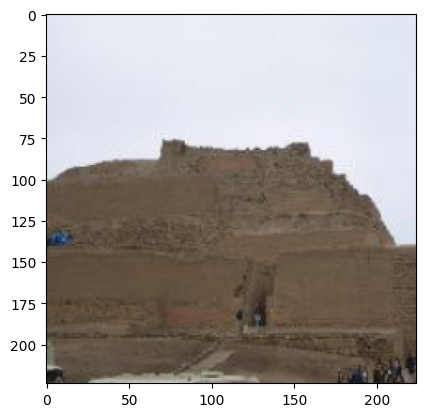

In [33]:
print("pred : ", pred, "labels : ", labels[rnd_idx])
print(labels_map[pred.cpu().item()], labels_map[labels[rnd_idx].cpu().item()])
plt.imshow(images[rnd_idx].permute(1, 2, 0).cpu())

In [34]:
def evaluation(model, testloader, loss_fn):
  total = 0   
  correct = 0
  test_loss = 0
  test_accuracy = 0

  # 전방향 예측을 구할 때는 gradient가 필요가 없음음
  with torch.no_grad():
    for images, labels in testloader: # 이터레이터로부터 next()가 호출되며 미니배치를 반환(images, labels)
      # 0. Data를 GPU로 보내기
      images, labels = images.to(device), labels.to(device)

      # 1. 입력 데이터 준비
      # not Flatten
      # images.resize_(images.size()[0], 784)
      
      # 2. 전방향(Forward) 예측
      logit = model(images) # 예측 점수
      _, preds = torch.max(logit, 1) # 배치에 대한 최종 예측
      # preds = logit.max(dim=1)[1] 
      correct += int((preds == labels).sum()) # 배치치 중 맞은 것의 개수가 correct에 누적
      total += labels.shape[0] # 배치 사이즈만큼씩 total에 누적

      loss = loss_fn(logit, labels)
      test_loss += loss.item() # tensor에서 값을 꺼내와서, 배치의 loss 평균값을 valid_loss에 누적

    test_accuracy = correct / total
   
  print('Test Loss : {:.3f}'.format(test_loss/len(testloader)), 
        'Test Accuracy : {:.3f}'.format(test_accuracy))

model.eval()
evaluation(model, testloader, loss_fn)  

Test Loss : 0.552 Test Accuracy : 0.818


In [36]:
# 현재 모델에 저장되어 있는 모델 파라미터터
model.state_dict().keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.3.weight', 'features.3.bias', 'features.6.weight', 'features.6.bias', 'features.8.weight', 'features.8.bias', 'features.10.weight', 'features.10.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias'])

In [37]:
torch.save(model.state_dict(), 'last_checkpoint.pth')

In [ ]:
# 시간이 흐른뒤 다시 모델 가져오기
last_state_dict = torch.load('last_checkpoint.pth')

In [ ]:
last_state_dict.keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.3.bias', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.7.bias', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.10.bias', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.14.bias', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.17.bias', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 

In [ ]:
# 읽어들인 모델 파라미터는 모델 아키텍처에 연결을 시켜줘야 함
# load_state_dict() 사용
last_model = model
last_model.to(device)
last_model.load_state_dict(last_state_dict)

<All keys matched successfully>

In [ ]:
last_model.eval()
evaluation(last_model, testloader, loss_fn)  

Test Loss : 0.091 Test Accuracy : 0.980


In [ ]:
# valid loss or accuracy 기준 best model
best_state_dict = torch.load('best_checkpoint.pth')
best_model = model
best_model.to(device)
best_model.load_state_dict(best_state_dict)

<All keys matched successfully>

In [ ]:
best_model.eval()
evaluation(best_model, testloader, loss_fn)

Test Loss : 0.062 Test Accuracy : 0.985


In [ ]:
#best_state_dict['conv_block1.0.weight']

In [ ]:
#last_state_dict['conv_block1.0.weight']